In [43]:
# 3_Advanced_Metrics.ipynb

# ===========================================
# Step 0: Environment Setup & Data Loading
# ===========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

# Define GitHub raw data paths
url_base = "https://raw.githubusercontent.com/zingeroff/Restaurant_Sales_Analysis/main/data"

# Load cleaned orders data
orders_df = pd.read_csv(f"{url_base}/orders_cleaned.csv")

# Load menu data for cost information
menu_df = pd.read_csv(f"{url_base}/menu-data.csv")



print("Data loaded successfully!")
print("Orders shape:", orders_df.shape)
print("Menu shape:", menu_df.shape)


Data loaded successfully!
Orders shape: (150383, 9)
Menu shape: (45, 5)


In [5]:
# ===========================================
# Step 1: Compute COGS, Profit, Profit Margin
# ===========================================

# Merge orders with menu to retrieve cost info
merged_df = pd.merge(orders_df, menu_df, on='menu_item_id', how='left')

# Calculate cost of goods sold (COGS) for each order line
merged_df['cogs'] = merged_df['cost ($)'] * merged_df['quantity']

# Calculate profit for each order line
merged_df['profit'] = merged_df['total_price ($)'] - merged_df['cogs']

# Convert profit margin into a percentage (rounded to 1 decimal place)
merged_df['profit_margin_percent'] = (
    (merged_df['profit'] / merged_df['total_price ($)']) * 100
).round(1)

print("Profit margin calculated for each order line.")
print(merged_df[['quantity', 'total_price ($)', 'cogs', 'profit', 'profit_margin_percent']].head(10))


Profit margin calculated for each order line.
   quantity  total_price ($)  cogs  profit  profit_margin_percent
0         3            38.97  15.6   23.37                   60.0
1         3             8.97   3.6    5.37                   59.9
2         1            13.50   5.4    8.10                   60.0
3         1             3.50   1.4    2.10                   60.0
4         3            32.97  13.2   19.77                   60.0
5         1             2.99   1.2    1.79                   59.9
6         3            43.50  17.4   26.10                   60.0
7         3            11.97   4.8    7.17                   59.9
8         2             7.98   3.2    4.78                   59.9
9         1            14.99   6.0    8.99                   60.0


In [6]:
# ===========================================
# Step 2.1: Overall Profit Margin (%)
# ===========================================
total_profit = merged_df['profit'].sum()
total_sales = merged_df['total_price ($)'].sum()

overall_margin_percent = (total_profit / total_sales) * 100
overall_margin_percent = round(overall_margin_percent, 1)

print(f"Overall Profit Margin: {overall_margin_percent}%")


Overall Profit Margin: 59.4%


In [7]:
# ===========================================
# Step 2.2: Average Items per Order
# ===========================================
unique_orders_count = merged_df['order_id'].nunique()
total_items = merged_df['quantity'].sum()

avg_items_per_order = total_items / unique_orders_count
print(f"Average items per order: {avg_items_per_order:.2f}")


Average items per order: 4.52


In [10]:
# ===========================================
# Step 2.3: Average Revenue per Guest
# ===========================================
revenue_by_guest = merged_df.groupby('client_id')['total_price ($)'].sum().reset_index()
avg_revenue_per_guest = revenue_by_guest['total_price ($)'].mean()

print(f"Average revenue per guest: ${avg_revenue_per_guest:,.2f}")


Average revenue per guest: $2,667.02


In [24]:
# ===========================================
# Step 2.4: Referral Source Analysis
# ===========================================
# Load guests to merge referral info
guests_df = pd.read_csv(f"{url_base}/guests.csv")
merged_all = pd.merge(merged_df, guests_df, left_on='client_id', right_on='guest_id', how='left')

referral_group = merged_all.groupby('referral_source')['total_price ($)'].sum().reset_index()
referral_group.rename(columns={'total_price ($)':'total_revenue'}, inplace=True)
referral_group.sort_values(by='total_revenue', ascending=False, inplace=True)


print("\nRevenue by referral source:")
print(referral_group)



Revenue by referral source:
  referral_source  total_revenue
3    Social Media      813517.70
4   Word of Mouth      758983.06
0   Advertisement      470709.11
1     Google Maps      322541.82
2           Other      269262.87


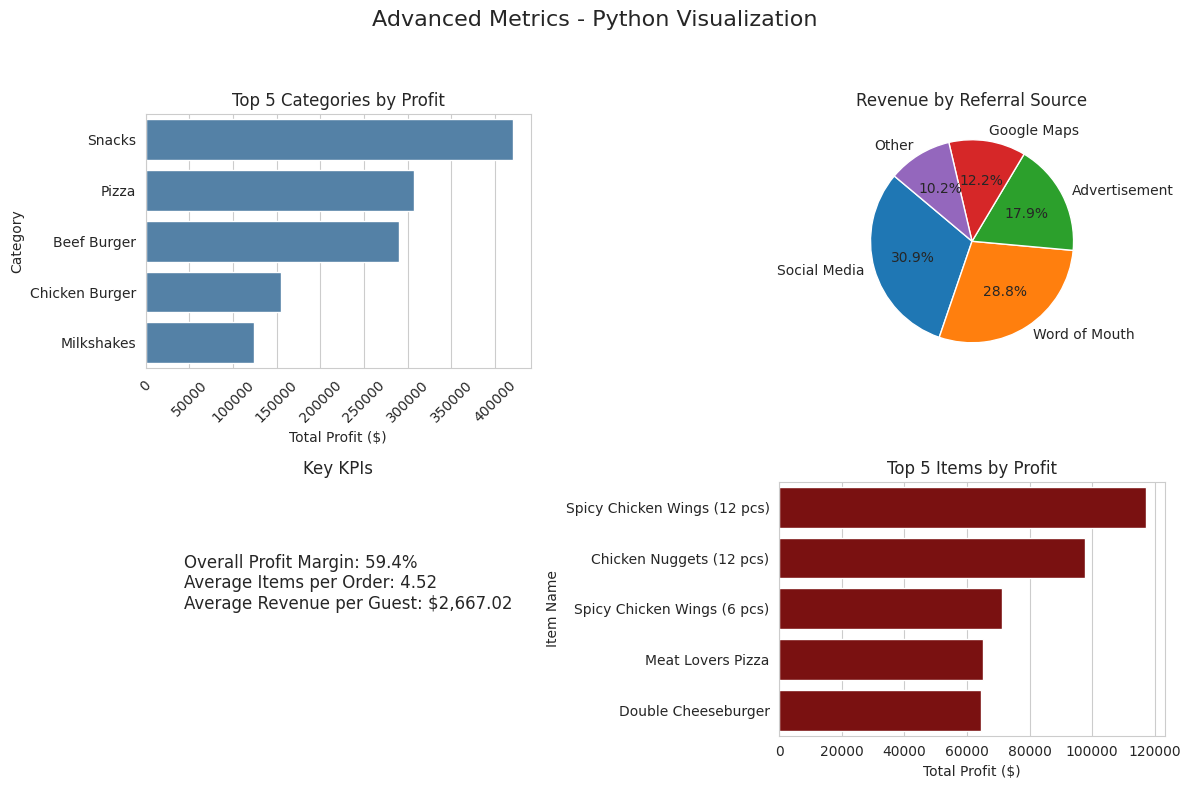

In [63]:
# ===========================================
# Step 3: Visualization
# ===========================================


# 3.1 Top 5 categories by total profit
top_cat = merged_df.groupby('category')['profit'].sum().reset_index()
top_cat.rename(columns={'profit': 'total_profit ($)'}, inplace=True)
top_cat = top_cat.sort_values('total_profit ($)', ascending=False).head(5)

# 3.2 Referral data (already in referral_group from step 2.4)
# referral_group has columns: referral_source, total_revenue

# We'll also prepare KPI variables from step 2:
# overall_margin_percent, avg_items_per_order, avg_revenue_per_guest

# 4) Fourth visualization: Top 5 items by profit
top_items = merged_df.groupby('item_name')['profit'].sum().reset_index()
top_items.rename(columns={'profit': 'total_profit ($)'}, inplace=True)
top_items = top_items.sort_values('total_profit ($)', ascending=False).head(5)


# Сreate a 2x2 subplot for a mini-dashboard
fig, axes = plt.subplots(2, 2, figsize=(12,8))
fig.suptitle("Advanced Metrics - Python Visualization", fontsize=16)

# --------------------------------------
# Subplot (0,0): Top Categories by Profit
# --------------------------------------
sns.barplot(
    data=top_cat,
    x='total_profit ($)',
    y='category',
    color='steelblue',
    ax=axes[0,0]
)
axes[0,0].set_title("Top 5 Categories by Profit")
axes[0,0].set_xlabel("Total Profit ($)")
axes[0,0].set_ylabel("Category")
axes[0,0].tick_params(axis='x', labelrotation=45)

# --------------------------------------
# Subplot (0,1): Referral Source (Pie Chart)
# --------------------------------------
axes[0,1].set_title("Revenue by Referral Source")
if not referral_group.empty:
    axes[0,1].pie(
        referral_group['total_revenue'],
        labels=referral_group['referral_source'],
        autopct='%1.1f%%',
        startangle=140
    )
else:
    axes[0,1].text(0.5, 0.5, "No referral data", ha='center', va='center')

# --------------------------------------
# Subplot (1,0): Key KPIs (Text)
# --------------------------------------
axes[1,0].axis('off')
axes[1,0].set_title("Key KPIs", fontsize=12)

kpi_text = f"""
Overall Profit Margin: {overall_margin_percent}%
Average Items per Order: {avg_items_per_order:.2f}
Average Revenue per Guest: ${avg_revenue_per_guest:,.2f}
"""
axes[1,0].text(
    0.1, 0.6,
    kpi_text,
    fontsize=12,
    verticalalignment='center'
)

# ----------------------------------------------------------------
# Subplot (1,1): Top 5 Items by Profit
# ----------------------------------------------------------------
sns.barplot(
    data=top_items,
    x='total_profit ($)',
    y='item_name',
    color='darkred',
    ax=axes[1,1]
)
axes[1,1].set_title("Top 5 Items by Profit")
axes[1,1].set_xlabel("Total Profit ($)")
axes[1,1].set_ylabel("Item Name")

plt.tight_layout(rect=[0,0,1,0.94])
plt.show()




### Key Insights from Advanced Metrics Analysis

#### 1. Most Profitable Categories  
- **Snacks** lead in profitability, followed by **Pizza** and **Beef Burgers**, indicating that smaller items contribute significantly to revenue.  
- **Milkshakes** and **Chicken Burgers** generate the least profit among the top five, suggesting they may have lower margins or lower sales volume.

#### 2. Top 5 Most Profitable Items  
- **Spicy Chicken Wings (12 pcs)** and **Chicken Nuggets (12 pcs)** are the highest-profit items, likely due to high demand and favorable pricing.  
- **Meat Lovers Pizza** and **Double Cheeseburger** also generate substantial profit, making them key menu items to promote.

#### 3. Revenue by Referral Source  
- **Social Media (30.9%)** and **Word of Mouth (28.8%)** are the two most significant sources of customer acquisition, highlighting the importance of organic marketing strategies.  
- **Google Maps (12.2%)** and **Advertisement (17.9%)** still contribute to revenue but may require optimization for better returns.

#### 4. Key KPIs  
- **Overall Profit Margin:** 59.4%, suggesting a strong balance between pricing and cost efficiency.  
- **Average Items per Order:** 4.52, indicating customers typically purchase multiple items per visit.  
- **Average Revenue per Guest:** $2,667.02, providing a clear benchmark for customer value.

---

### Actionable Recommendations  
- **Leverage Popular Items for Promotions:** High-profit items like **Spicy Chicken Wings** and **Chicken Nuggets** should be featured in promotional campaigns.  
- **Optimize Referral Channels:** Given the impact of **Social Media** and **Word of Mouth**, the restaurant should further invest in engagement and referral programs.  
- **Improve Lower-Performing Categories:** **Milkshakes** and **Chicken Burgers** could benefit from pricing adjustments or bundling strategies to enhance profitability.  

These insights help guide menu optimization, pricing strategies, and marketing focus for sustained business growth.
